## Classification Model

### Import Libraries:

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import split_folders
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Flatten,Dropout
import matplotlib.pyplot as plt
import cv2
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.utils import class_weight 
from tensorflow.keras.optimizers import Adam
import gtts
from playsound import playsound
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RepeatedKFold, cross_val_score
from warnings import filterwarnings
filterwarnings('ignore')

### Image Preprocessing:

In [2]:
# Splitting data into Train and Validation 
split_folders.ratio("D:/MTech-DSML/DATA/Traffic Lights",output="D:/MTech-DSML/DATA/Traffic Lights_split",seed=10,ratio=(0.8,0.2))

Copying files: 2485 files [00:01, 1770.42 files/s]


In [3]:
train_datagen=ImageDataGenerator(rescale=1./255,
        zoom_range=0.2,                         
        horizontal_flip=True)

train_data=train_datagen.flow_from_directory("D:/MTech-DSML/DATA/Traffic Lights_split/train",target_size=(64,64),
        batch_size=32,
        class_mode='categorical')

Found 1987 images belonging to 3 classes.


In [4]:
val_datagen=ImageDataGenerator(rescale=1./255)

val_data=val_datagen.flow_from_directory("D:/MTech-DSML/DATA/Traffic Lights_split/val",target_size=(64, 64),
        batch_size=32,
        class_mode='categorical')

Found 498 images belonging to 3 classes.


In [5]:
# Assigning weights to labels since the classes are imbalanced
class_weights = class_weight.compute_class_weight(
           'balanced',
            np.unique(train_data.classes), 
            train_data.classes)

train_class_weights = dict(enumerate(class_weights))
train_class_weights

{0: 1.2835917312661498, 1: 0.5219332807985291, 2: 3.278877887788779}

### Building a Classification Model:

In [6]:
# Using a VGG16 pretrained model for classification

model=VGG16(input_shape=(64,64,3),include_top=False)

In [7]:
# Freezing the top layers and adding new Dense layers to the VGG16 model and only training them
# Train the weights of only the dense layers 
for layers in model.layers:
    if('dense' not in layers.name):
        layers.trainable=False
    if('dense' in layers.name):
        layers.trainable=True

In [8]:
#Adding the new dense layers to the VGG19 model
vgg_model=Sequential([model,
                          Flatten(),
                          Dense(64,activation='relu'),
                          Dense(32,activation='relu'),
                          Dense(3,activation='softmax')])
vgg_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                131136    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 99        
Total params: 14,848,003
Trainable params: 133,315
Non-trainable params: 14,714,688
_________________________________________________________________


In [9]:
# Compiling the model
optimizer=Adam(learning_rate=1e-3)
vgg_model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

In [10]:
# Fitting the model 

my_model=vgg_model.fit_generator(train_data,steps_per_epoch=1987 //32,epochs=25,validation_data=val_data,validation_steps=498 //32,class_weight=train_class_weights)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/25
62/62 [==============================] - 36s 569ms/step - loss: 1.0772 - accuracy: 0.4194 - val_loss: 1.0346 - val_accuracy: 0.4417
Epoch 2/25
62/62 [==============================] - 26s 416ms/step - loss: 0.9956 - accuracy: 0.5166 - val_loss: 0.8268 - val_accuracy: 0.6604
Epoch 3/25
62/62 [==============================] - 25s 409ms/step - loss: 0.9256 - accuracy: 0.5627 - val_loss: 0.9066 - val_accuracy: 0.5729
Epoch 4/25
62/62 [==============================] - 26s 424ms/step - loss: 0.8654 - accuracy: 0.6143 - val_loss: 0.8233 - val_accuracy: 0.6292
Epoch 5/25
62/62 [==============================] - 27s 435ms/step - loss: 0.7772 - accuracy: 0.6777 - val_loss: 0.7239 - val_accuracy: 0.6708
Epoch 6/25
62/62 [==============================] - 25s 408ms/step - loss: 0.8066 - accuracy: 0.6327 - val_loss: 0.7167 - val_accuracy: 0.6854
Epoc

### Inference: 

- The model was trained on a pretrained VGG16 using 1987  images for training and 498 images for validation

- Giving an initial value of 1e-3 to the learning_rate of Adam optimizer, the model was compiled and trained.

- The model built gives a good accuracy i.e on Train data we get an accuracy of 78.9% and on Test data we get 76.8%

- The model gives a categorical cross-entropy loss of 0.46 on Train data and 0.48 on Test data.

In [11]:
# Saving the model
vgg_model.save("vgg_model_new_copy")

INFO:tensorflow:Assets written to: vgg_model_new_copy\assets


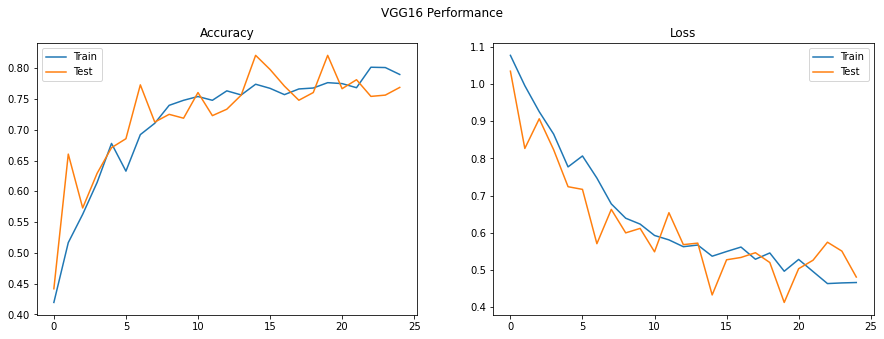

In [12]:
# Comparing performance metrics of the model
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(my_model.history['accuracy'],label='Train')
plt.plot(my_model.history['val_accuracy'],label='Test')
plt.title("Accuracy")
plt.legend()

plt.subplot(122)
plt.plot(my_model.history['loss'],label='Train')
plt.plot(my_model.history['val_loss'],label='Test')
plt.title("Loss")
plt.legend()

plt.suptitle("VGG16 Performance")
plt.show()

## Object Detection Model

### Initialising pretrained object Detection Model YOLO v4

In [17]:
# Reading the deep learning Network by giving the pretrained model weights and the model configuration as parameters:

net=cv2.dnn.readNet("yolov3.weights","yolov3.cfg")

# Using Coco, a large scale dataset which consists of 80 classes to label the objects in an image:

with open("coco.names","r") as f:
    classes=[i.strip() for i in f.readlines()]
    
# Output layers of Yolo v3:

output=net.getUnconnectedOutLayersNames()

# Different colored boxes for different objects:

colors=np.random.uniform(0,255,size=(len(classes),3))

### Defining a function for detecting objects in an image :

In [18]:
def object_(image_path,cropped_path):
    
    img=cv2.imread(image_path)
    height,width,channels=img.shape
    
    plt.figure(figsize=(17,5))
    plt.subplot(121)
    rgb=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.title("Original Image")
    plt.suptitle("Prediction")
    plt.imshow(rgb)
    
    #Detecting the objects from the image:
    blob=cv2.dnn.blobFromImage(img, 0.00392, (448, 448), (0, 0, 0), True, crop=False)
    
    #Giving these blobs as inputs to the network:
    net.setInput(blob)

    # Perform forward propagation to compute the output by passing the names of the output layers as parameters:
    outs=net.forward(output)
    
    # Obtaining the labels,boxes and confidence of the objects in the image:

    class_ids=[]
    boxes=[]
    confidences=[]

    for out in outs:
        for detection in out:
            scores=detection[5:]
            class_id=np.argmax(scores)
            confidence=scores[class_id]
            

            if confidence>0.9:

                # Co-ordinates of the box:
                center_x=int(detection[0]*width)
                center_y=int(detection[1]*height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                x = int(center_x - w /2)
                y = int(center_y - h /2)

                boxes.append([x,y,w,h])
                confidences.append(float(confidence))
                class_ids.append(class_id)
    
   # Obtaining only the class_id,boxes,and confidence for traffic lights 

   

    class_ids_new=[]
    boxes_new=[]
    confidences_new=[]
    
    # Obtaining just the Traffic light label 
    indexes=[]
    for index,num in enumerate(class_ids):
        if num==9:
            indexes.append(index)

        
    for i in indexes:
        class_ids_new.append(class_ids[i])
        boxes_new.append(boxes[i])
        confidences_new.append(confidences[i])
    
    
    
    
    # Performing Non Maximum Supression to avoid overlapping of the boxes holding the same object :

    indexes=cv2.dnn.NMSBoxes(boxes_new,confidences_new,0.1,0.1)
    
    # Building the Object Detector:
    font=cv2.FONT_HERSHEY_COMPLEX_SMALL
    for i in range(len(boxes_new)):
        if i in indexes:
            x,y,w,h=boxes_new[i]
        
            color=colors[i]
            cv2.rectangle(img,(2*x//4,2*y//4),(x+w+100,y+h+100),color,2)
    
            
    # Plotting the Object Detected image        
    plt.subplot(122)
    rgb1=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.title("Object Detected")
    plt.imshow(rgb1)
    plt.show()
    
    
    
    # Cropping Objects from the image
    box=boxes_new[0]
    im=Image.open(image_path)
    plt.figure(figsize=(17,5))
    plt.subplot(131)
    
    global im1
    im1 = im.crop((2*box[0]//4,2*box[1]//4,box[0]+box[2]+100,box[1]+box[3]+100))
    plt.title("Cropped Image")
    plt.imshow(im1)
    im1.save("D:/MTech-DSML/DATA/Traffic Light Detection/crop.jpg")
    
    
    
    test_image = image.load_img(cropped_path, target_size = (64, 64))
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis = 0)
    result = vgg_model.predict(test_image/255.)
    prediction=list(train_data.class_indices.keys())[np.argmax(result)]
    if prediction=='red':
        # make request to google to get synthesis
        tts = gtts.gTTS("Stop")
        # save the audio file
        #tts.save("stop_voice.mp3")
        # play the audio file
        playsound("stop_voice.mp3")
    elif prediction=='yellow':
        tts = gtts.gTTS("Get Ready")
        #tts.save("get_ready_voice.mp3")
        playsound("get_ready_voice.mp3")
    elif prediction=='green':
        tts = gtts.gTTS("Go")
        #tts.save("go_voice.mp3")
        playsound("go_voice.mp3")
    else:
        tts = gtts.gTTS("No signal Detected")
        tts.save("no_signal_voice.mp3")
        playsound("no_signal_voice.mp3")
        
    
    plt.show()

    

## Prediction

### Image 1: Red Light

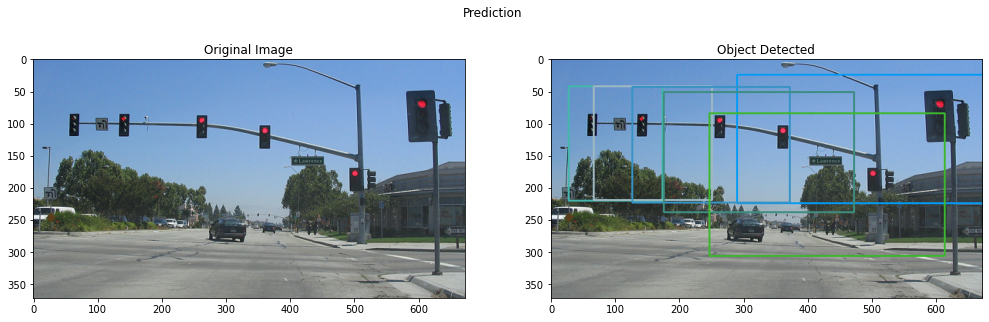

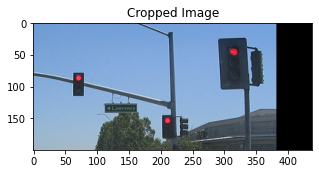

In [63]:
object_("D:/MTech-DSML/DATA/Traffic Light Detection/red light 3.jpeg","D:/MTech-DSML/DATA/Traffic Light Detection/crop.jpg")

### Image 2 : Yellow Light

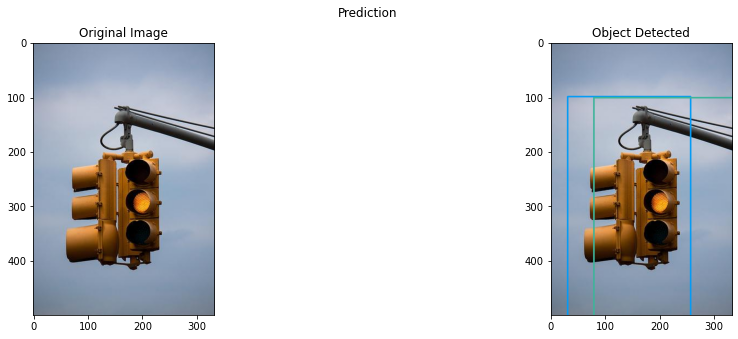

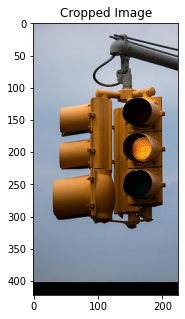

In [64]:
object_("D:/MTech-DSML/DATA\Traffic Light Detection/yellow.jpg","D:/MTech-DSML/DATA/Traffic Light Detection/crop.jpg")

### Image 3 : Green Light

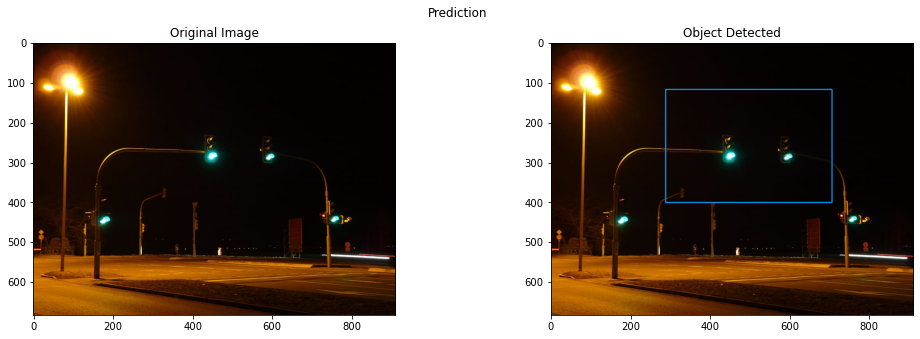

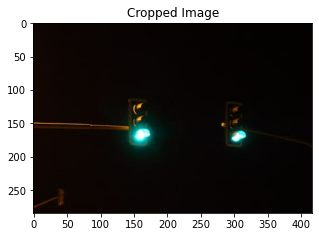

In [65]:
object_("D:/MTech-DSML/DATA\Traffic Light Detection/green light 4.jpg","D:/MTech-DSML/DATA/Traffic Light Detection/crop.jpg")

### Conclusion:

People suffering from color blindness and other forms of visual impairment find it difficult to drive vehicles since they can’t recognize traffic signals clearly. This model would come in handy to predict the color of the traffic light by giving a form of audio output of the action expected such as Stop, Get Ready & Go  for the Traffic Lights Red, Yellow, Green respectively.The project is not limited to just the visually challenged.It is highly convenient to use during heavy traffic to recognise traffic lights.
